In [2]:
%matplotlib inline

In [3]:
import os
import sys

In [4]:
print sys.version

2.7.14 (default, Feb 15 2018, 20:22:28) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
import xgboost as xgb
import pymatgen as mg
import datetime as dt

/usr/local/lib/python2.7/site-packages/pymatgen/__init__.py:87: UserWarning: 
Pymatgen will drop Py2k support from v2019.1.1. Pls consult the documentation
at https://www.pymatgen.org for more details.
  at https://www.pymatgen.org for more details.""")


In [7]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [8]:
from utils import rmsle

In [9]:
from dataload import load_features

### Load data

In [10]:
DATA_DIR = './data'

In [11]:
train, test = load_features(DATA_DIR, with_ext=True, with_geo=True)

### Build train and test data sets

In [12]:
X_train = train.drop(['id', 'natoms', 'spacegroup',
                      'alpha', 'beta', 'gamma',
                      'ga', 'o_cnt', 'cellvol', 'o_fraction', 'avg_mass',
                      'bandgap', 'E0'], axis=1)
X_test = test.drop(['id', 'natoms', 'spacegroup',
                    'alpha', 'beta', 'gamma',
                    'ga', 'o_cnt', 'cellvol', 'o_fraction', 'avg_mass'], axis=1)

In [13]:
# Use log1p of energies to correct for skew
y_bg_train = train['bandgap']
y_e0_train = np.log1p(train['E0'])

In [14]:
# One-hot encode spacegroup_natoms
X_train = pd.concat([X_train.drop('spacegroup_natoms', axis=1),
                    pd.get_dummies(X_train['spacegroup_natoms'])], axis=1)
X_test = pd.concat([X_test.drop('spacegroup_natoms', axis=1),
                    pd.get_dummies(X_test['spacegroup_natoms'])], axis=1)

### Build Sklearn Model with XGBRegressor (no PCA yet, optimal hyperparams)

In [15]:
pa_bg = {'learning_rate': 0.02,      # Step size shrinkage used in update (Learning rate)
         'reg_alpha': 0.05,          # L1 regularization term on weights
         'n_estimators': 625,
         'max_depth': 3,
         'subsample': 1,
         'colsample_bytree': 0.90,
         'colsample_bylevel': 0.90,
         'silent': True,
         'random_state': 42,
         'objective': 'reg:linear'}
pa_e0 = {'learning_rate': 0.05,      # Step size shrinkage used in update (Learning rate)
         'reg_alpha': 0.10,          # L1 regularization term on weights
         'n_estimators': 300,
         'max_depth': 4,
         'subsample': 1,
         'colsample_bytree': 0.90,
         'colsample_bylevel': 0.90,
         'silent': True,
         'random_state': 42,
         'objective': 'reg:linear'}

In [16]:
# Estimator pipeline
est_bg = Pipeline([
    ('scaler', StandardScaler()),
    ('xgbreg', XGBRegressor(**pa_bg)),
])
est_e0 = Pipeline([
    ('scaler', StandardScaler()),
    ('xgbreg', XGBRegressor(**pa_e0)),
])

In [17]:
est_bg.fit(X_train, y_bg_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbreg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=625,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [18]:
est_e0.fit(X_train, y_e0_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbreg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

### Output predictions

In [19]:
predicted_bg = est_bg.predict(X_test)
predicted_e0 = np.expm1(est_e0.predict(X_test))

In [20]:
predicted = pd.DataFrame({'formation_energy_ev_natom': predicted_e0,
                          'bandgap_energy_ev': predicted_bg}) \
              .reset_index().rename(columns={'index': 'id'})
predicted['id'] += 1

In [21]:
predicted.head()

,id,bandgap_energy_ev,formation_energy_ev_natom
0,1,1.491695,0.225013
1,2,3.653866,0.075040
2,3,3.435462,0.174545
3,4,3.047779,0.031543
4,5,1.523106,0.150785


In [22]:
err_e0 = rmsle(np.expm1(est_e0.predict(X_train)), np.expm1(y_e0_train))
err_bg = rmsle(est_bg.predict(X_train), y_bg_train)

In [23]:
# Training RMSLE values
print "RMSLE BG: {}, RMSLE E0: {}, RMSLE AVG: {}".format(err_bg, err_e0,
                                                         0.5 * (err_bg + err_e0))

RMSLE BG: 0.0652129454193, RMSLE E0: 0.016573680748, RMSLE AVG: 0.0408933130836


### Feature importance from model

In [24]:
from xgboost import plot_importance

In [25]:
features = X_train.columns.tolist()

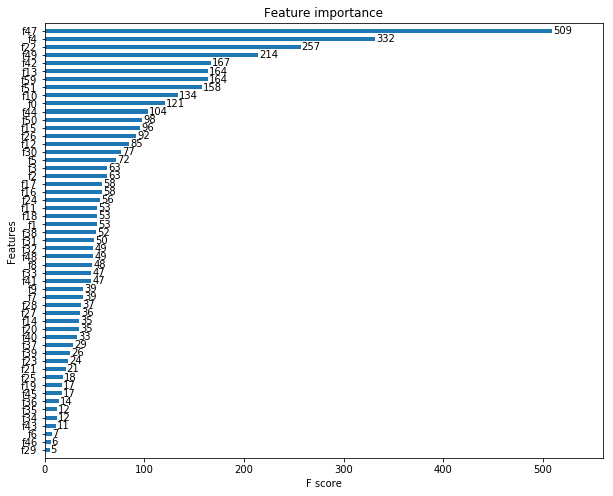

In [26]:
figure, ax = plt.subplots(figsize=(10, 8))
plot_importance(est_bg.named_steps['xgbreg'], height=0.5, grid=False, ax=ax);

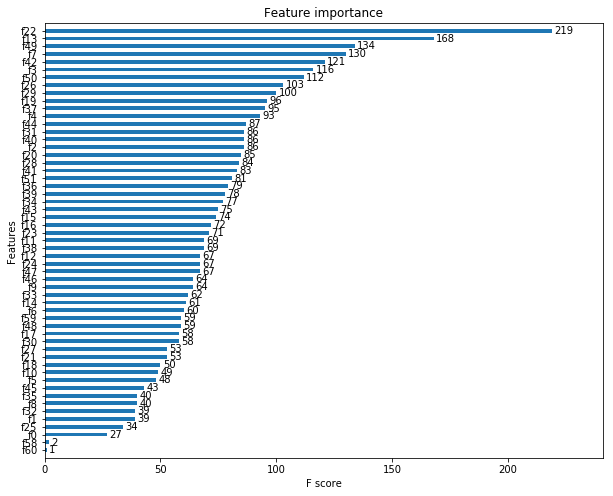

In [27]:
figure, ax = plt.subplots(figsize=(10, 8))
plot_importance(est_e0.named_steps['xgbreg'], height=0.5, grid=False, ax=ax);

In [28]:
fi_bg = list(est_bg.named_steps['xgbreg'].feature_importances_*4116)
fi_e0 = list(est_e0.named_steps['xgbreg'].feature_importances_*4093)

In [29]:
findex = ['f{}'.format(i) for i in range(len(features))]

In [30]:
fi_df = pd.DataFrame(map(list, zip(*[findex, features, fi_bg, fi_e0])),
                     columns=['fid', 'feature_name', 'feature_importance_bg', 'feature_importance_e0'])

In [31]:
fi_df_topbg = fi_df.sort_values('feature_importance_bg', ascending=False)[:27]
fi_df_tope0 = fi_df.sort_values('feature_importance_e0', ascending=False)[:44]

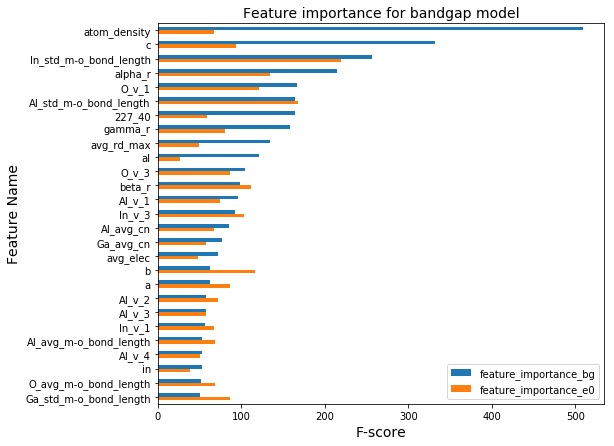

In [32]:
fi_df_topbg.plot.barh(x='feature_name',
                      figsize=(8,7))
plt.xlabel('F-score', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)
plt.title('Feature importance for bandgap model', fontsize=14)
plt.gca().invert_yaxis();

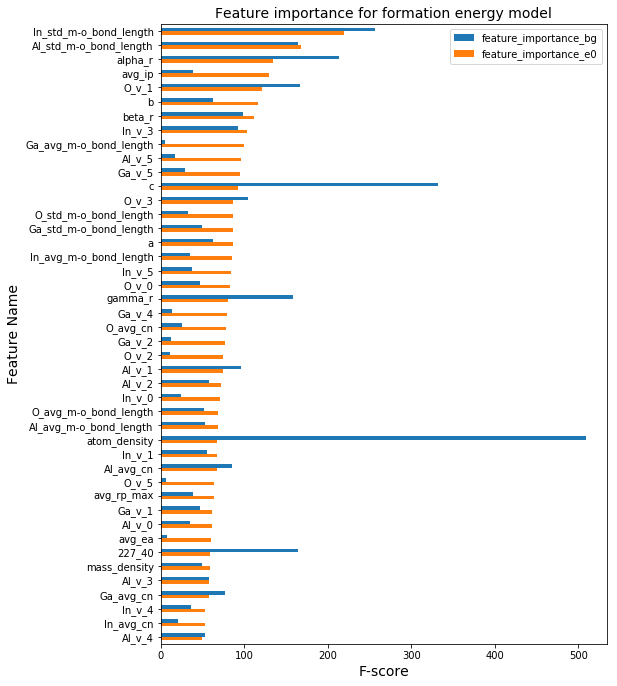

In [33]:
fi_df_tope0.plot.barh(x='feature_name',
                      figsize=(8,11.4))
plt.xlabel('F-score', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)
plt.title('Feature importance for formation energy model', fontsize=14)
plt.gca().invert_yaxis();